In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

# TODO
1- Survival analysis whole dataset
2- Survival analysis age threshold
2- Survival analysis subset, subset + age
3- Survival analysis on model's prediction, comparison with previous 

Create duration, observation features
- Duration: difference dates
- Observation: death or not


In [5]:
df = pd.read_csv("./data/data/data_cvd.csv", index_col=0, decimal='.')
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="%Y/%m/%d")
df["Data prelievo (1)"] = pd.to_datetime(df["Data prelievo (1)"], format="%Y/%m/%d")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5820 entries, 395 to 1193
Data columns (total 80 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Age (1)                                     5820 non-null   int64         
 1   Gender (Male = 1)                           5820 non-null   int64         
 2   Angina                                      5820 non-null   int64         
 3   Previous CABG                               5820 non-null   int64         
 4   Previous PCI                                5820 non-null   int64         
 5   Previous 
Myocardial Infarction             5820 non-null   int64         
 6   Acute 
Myocardial Infarction                5820 non-null   int64         
 7   Angiography                                 5820 non-null   int64         
 8   Vessels                                     3562 non-null   float64       
 9   CAD   

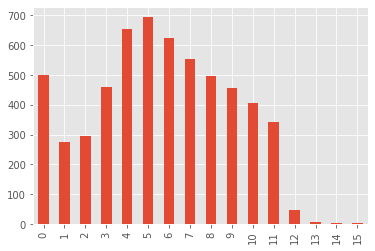

In [15]:
# duration and observation features
df_surv = df.copy()
df_surv["duration"] = (df["Follow Up Data"] - df["Data prelievo (1)"]).map(lambda x: x.days//365)
df_surv["duration"].value_counts().sort_index().plot(kind='bar')

df_surv["observation"] = df[""]